In this notebook we determine reasonable values for parameters that were not measured directly in previous studies.

# Place-tuned synaptic weights
### Result: W_A_PL_CA3 = 0.017

We choose a synaptic weight for place-tuned inputs onto CA3 PCs that yields an EPSP with a peak magnitude of approximately 4 mV, as measured by Hyun et al., (2015).

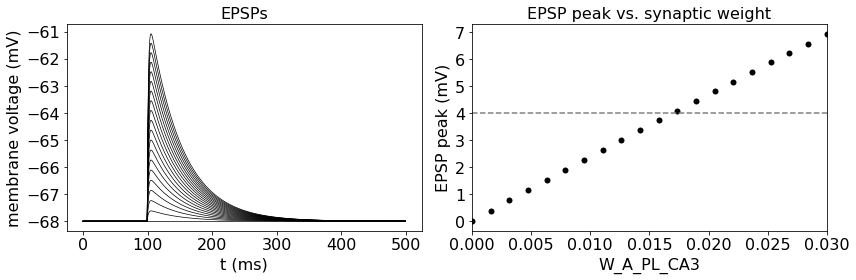

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

WS_AMPA = np.linspace(0, .03, 20)

ES_SYN = {'AMPA': P.E_A}
TS_SYN = {'AMPA': P.T_A}
WS_RCR = {'AMPA': np.array([[0.]])}

# simulation parameters
DUR = 0.5  # (s)
INPUT_TIME = 0.1  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/P.DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([P.E_L_PC])
gs_init = {'AMPA': np.array([0.])}

epsp_peaks = np.nan * np.zeros(WS_AMPA.shape)

for ctr, w_ampa in enumerate(WS_AMPA):
    # make upstream weight matrix
    ws_up = {'AMPA': np.array([[w_ampa]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M_PC, e_leak=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    epsp_peaks[ctr] = resp.vs.max() - resp.vs.min()

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('EPSPs')

axs[1].scatter(WS_AMPA, 1000 * epsp_peaks, c='k', lw=0)
axs[1].axhline(4, color='gray', ls='--')
axs[1].set_xlim(WS_AMPA[0], WS_AMPA[-1])
axs[1].set_xlabel('W_A_PL_CA3')
axs[1].set_ylabel('EPSP peak (mV)')
axs[1].set_title('EPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

The above results suggest we should use an AMPA weight of about 0.017 for place-tuned inputs onto CA3 pyramidal cells.

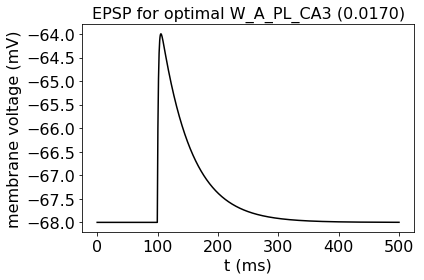

In [2]:
# show an EPSP from a place-tuned input with this AMPA weight
ws_up = {'AMPA': np.array([[P.W_A_PC_PL]])}

# make and run ntwk
ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_leak=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1000 * ts, 1000 * resp.vs, color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('EPSP for optimal W_A_PL_CA3 ({0:.4f})'.format(P.W_A_PC_PL))
set_font_size(ax, 16)

# Maximum place-tuned synaptic input rate
### Result: R_MAX_PL = 350 Hz

We choose this value such that the CA3 output firing rate is approximately 20 Hz when the maximum place-tuned synaptic input is presented to the neuron.

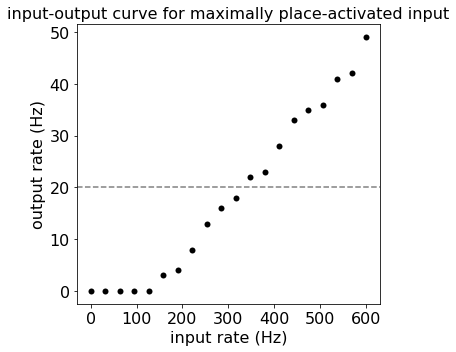

In [3]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size
from traj import upstream_spks_from_traj

import PARAMETERS as P

MAX_RATES_UP = np.linspace(0, 600, 20)

ES_SYN = {'AMPA': P.E_AMPA}
TS_SYN = {'AMPA': P.T_AMPA}
WS_RCR = {'AMPA': np.array([[0.]])}
WS_UP = {'AMPA': np.array([[P.W_A_PL_CA3]])}

# simulation parameters
DUR = 3  # (s)
SEED = 0
SPK_RATE_ITVL = (2, 3)

# make ntwk
ntwk = LIFNtwk(
    t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=WS_UP)

# loop over max synaptic input rate values
ts = np.arange(0, DUR, P.DT)
xys = np.zeros((len(ts), 2))
pfcs = np.zeros((2, 1))
stds = np.array([0.1])

spk_rate_itvl_mask = ((ts >= SPK_RATE_ITVL[0]) * (ts < SPK_RATE_ITVL[1])).astype(bool)

vs_init = np.array([P.E_LEAK])
gs_init = {'AMPA': np.array([0.])}

np.random.seed(SEED)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

spk_rates_out = np.nan * np.zeros(MAX_RATES_UP.shape)

for ctr, max_rate_up in enumerate(MAX_RATES_UP):
    
    # get upstream spikes and run ntwk
    max_rates = np.array([max_rate_up])
    spks_up = upstream_spks_from_traj(ts, xys, pfcs, stds, max_rates)
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # calculate spike rate
    itvl = SPK_RATE_ITVL[1] - SPK_RATE_ITVL[0]
    spk_rates_out[ctr] = resp.spks[spk_rate_itvl_mask].sum() / itvl

# plot output spk rate vs. input rate
ax.scatter(MAX_RATES_UP, spk_rates_out, color='k', lw=0)
ax.axhline(20, color='gray', ls='--')
ax.set_xlabel('input rate (Hz)')
ax.set_ylabel('output rate (Hz)')
ax.set_title('input-output curve for maximally place-activated input')

set_font_size(ax, 16)

These results suggest that an input rate of about 350 Hz will yield an output firing rate of about 20 Hz.

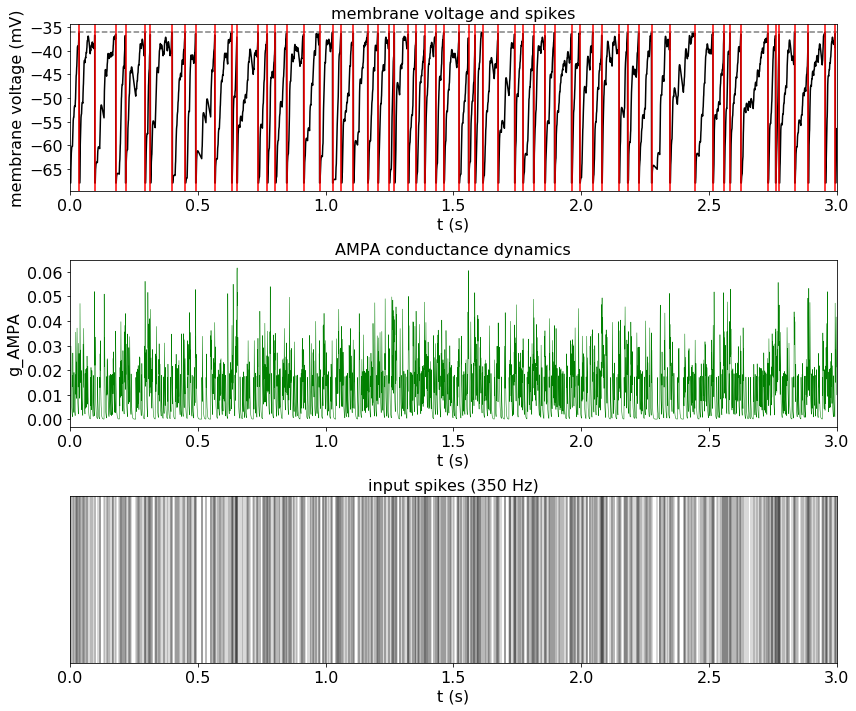

In [4]:
# show the membrane potential dynamics given this input rate
max_rates = np.array([P.R_MAX_PL])
spks_up = upstream_spks_from_traj(ts, xys, pfcs, stds, max_rates)

resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

# plot voltage, spiking response, AMPA conductance, and input spikes
fig, axs = plt.subplots(3, 1, figsize=(12, 10), tight_layout=True)

# voltage
axs[0].plot(ts, 1000 * resp.vs, color='k')
axs[0].axhline(1000 * P.V_TH, color='gray', ls='--')

# spikes
for spk_idx in resp.spks.nonzero()[0]:
    axs[0].axvline(spk_idx*P.DT, color='r')

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('membrane voltage and spikes')

# AMPA conductance
axs[1].plot(ts, resp.gs['AMPA'], color='g', lw=0.5)

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('g_AMPA')
axs[1].set_title('AMPA conductance dynamics')

# input spikes
for spk_idx in spks_up.nonzero()[0]:
    axs[2].axvline(spk_idx*P.DT, color='k', lw=.3)
    
axs[2].yaxis.set_visible(False)
axs[2].set_xlabel('t (s)')
axs[2].set_title('input spikes ({} Hz)'.format(P.R_MAX_PL))

for ax in axs:
    ax.set_xlim(ts[0], ts[-1])
    set_font_size(ax, 16)

# EC-CA3 initial and final synaptic weights
### Results: W_A_EC_CA3_I = 0.008, W_A_EC_CA3_F = 0.017

We choose synaptic weights to yield initial and final EPSP sizes of approximately 2 mV and 4 mV, respectively, as determined by Hyun, et al., (2013, 2015).

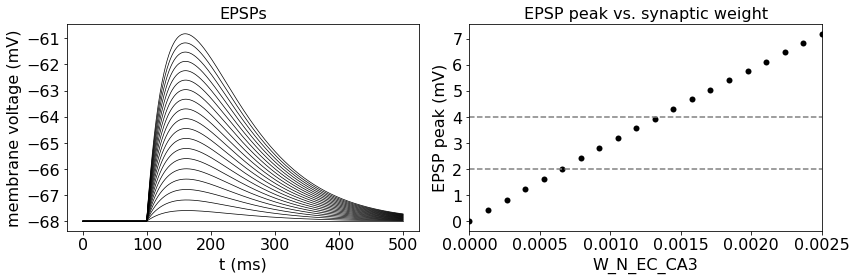

In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

WS_NMDA = np.linspace(0, .0025, 20)

# single unit parameters
ES_SYN = {'NMDA': P.E_NMDA}
TS_SYN = {'NMDA': P.T_NMDA}
WS_RCR = {'NMDA': np.array([[0.]])}

# simulation parameters
DUR = 0.5  # (s)
INPUT_TIME = 0.1  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/P.DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([P.E_LEAK])
gs_init = {'NMDA': np.array([0.])}

epsp_peaks = np.nan * np.zeros(WS_NMDA.shape)

for ctr, w_nmda in enumerate(WS_NMDA):
    # make upstream weight matrix
    ws_up = {'NMDA': np.array([[w_nmda]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    epsp_peaks[ctr] = resp.vs.max() - resp.vs.min()

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('EPSPs')

axs[1].scatter(WS_NMDA, 1000 * epsp_peaks, c='k', lw=0)
axs[1].axhline(2, color='gray', ls='--')
axs[1].axhline(4, color='gray', ls='--')
axs[1].set_xlim(WS_NMDA[0], WS_NMDA[-1])
axs[1].set_xlabel('W_N_EC_CA3')
axs[1].set_ylabel('EPSP peak (mV)')
axs[1].set_title('EPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

This result shows us that we should have an initial W_A_EC_CA3 ($w_A^{EC-CA3}$) of about a 0.00065 and a final W_A_EC_CA3 of about 0.000135.

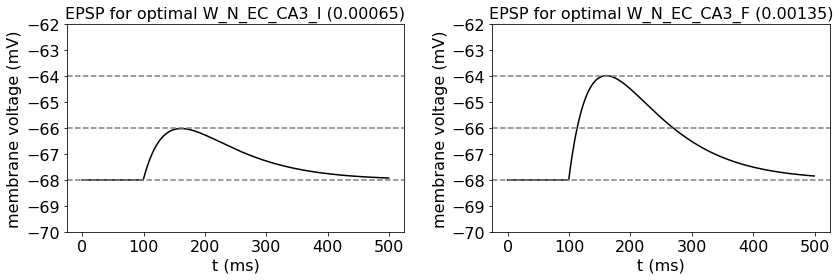

In [6]:
# show an EPSP from a place-tuned input with this AMPA weight
W_N_EC_CA3S = [P.W_N_EC_CA3_I, P.W_N_EC_CA3_F]
labels = ['W_N_EC_CA3_I', 'W_N_EC_CA3_F']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for ax, W_N_EC_CA3, label in zip(axs, W_N_EC_CA3S, labels):
    ws_up = {'NMDA': np.array([[W_N_EC_CA3]])}

    # make and run ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

    # make plot
    ax.plot(1000 * ts, 1000 * resp.vs, color='k')
    ax.set_ylim(-70, -62)
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('membrane voltage (mV)')
    ax.set_title('EPSP for optimal {0} ({1:.5f})'.format(label, W_N_EC_CA3))

for ax in axs:
    ax.axhline(1000*P.E_LEAK, color='gray', ls='--')
    ax.axhline(1000*(P.E_LEAK + 0.002), color='gray', ls='--')
    ax.axhline(1000*(P.E_LEAK + 0.004), color='gray', ls='--')
    set_font_size(ax, 16)

# EC-CA3 activity-dependent plasticity
### Results: T_W = 1 s, T_C = 1.5 s, C_S = 5, BETA_C = 0.2

Here we demonstrate a set of plasticity parameters ($\tau_w$, $\tau_c$, $c^*$, $\beta_c$; see [dynamics.ipynb](dynamics.ipynb)) that yields a near-doubling of the initial EC-CA3 synaptic weight following a fast spike train, but no change at all following a just a single spike or a too-slow spike train.

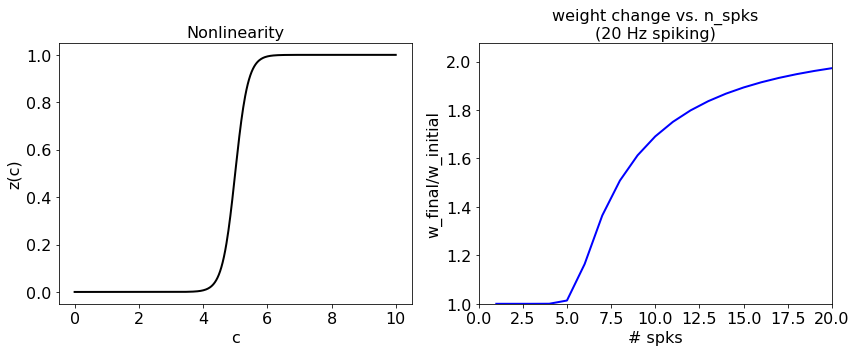

In [7]:
%reset -f
%matplotlib inline
import pdb
import matplotlib.pyplot as plt
import numpy as np

from ntwk import update_spk_ctr, update_plastic_weights, z
from plot import set_font_size

import PARAMETERS as P

FIRST_SPIKE_TIME = 1  # time of 1st spk (s)
DUR = 5  # simulation duration (s)

F = 20  # freq (Hz)

MAX_SPIKES = 20


n_spks_all = np.arange(1, MAX_SPIKES+1)
w_finals = np.nan * np.zeros(n_spks_all.shape)

for ctr, n_spks in enumerate(n_spks_all):
    
    # initialize structures for storing spk-counter and synaptic weight
    ts = np.arange(0, DUR, P.DT)
    cs = np.nan * np.zeros(ts.shape)
    ws = {'NMDA': np.nan * np.zeros((len(ts), 1))}
    
    cs[0] = 0
    ws['NMDA'][0] = P.W_N_EC_CA3_I
    
    # make spk train
    spks = np.zeros((len(ts), 1))
    t_spks = FIRST_SPIKE_TIME + np.arange(n_spks) / F
    
    for t_spk in t_spks:
        spks[int(t_spk/P.DT), 0] = 1
        
    # run simulation
    for step in range(1, len(ts)):
        
        # calc and store updated spk ctr
        cs_next = update_spk_ctr(spks[step], cs[step-1], t_c=P.T_C, dt=P.DT)
        cs[step] = cs_next
        
        # calc updated weights
        ws_prev = ws['NMDA'][step-1]
        ws_next = update_plastic_weights(
            cs=cs_next, ws_prev=ws_prev,
            c_s=P.C_S, beta_c=P.BETA_C, t_w=P.T_W,
            w_ec_ca3_max=P.W_N_EC_CA3_F, dt=P.DT)

        # store updated spk ctr and weights 
        cs[step] = cs_next
        ws['NMDA'][step] = ws_next
        
    # store final w
    w_finals[ctr] = ws['NMDA'][-1]
    
# plot z(c) and w_final vs. n_spks
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# z(c) vs. c
cs = np.linspace(0, 10, 500)
axs[0].plot(cs, z(cs, P.C_S, P.BETA_C), color='k', lw=2)
axs[0].set_xlabel('c')
axs[0].set_ylabel('z(c)')
axs[0].set_title('Nonlinearity')

# w_final vs. n_spks
axs[1].plot(n_spks_all, w_finals/P.W_N_EC_CA3_I, color='b', lw=2)
axs[1].set_xlim(0, MAX_SPIKES)
axs[1].set_ylim(1, P.W_N_EC_CA3_F/P.W_N_EC_CA3_I)
axs[1].set_xlabel('# spks')
axs[1].set_ylabel('w_final/w_initial')
axs[1].set_title('weight change vs. n_spks\n({} Hz spiking)'.format(F))

for ax in axs:
    set_font_size(ax, 16)

Here we see that with the parameters we've chosen, at least 5 spikes are required before any noticeable weight change occurs, with the synaptic weight nearly doubling once 15-20 spikes occur. The parameters used to make the above plot were:

$\tau_w = 1s$

$\tau_c = 1.5s$

$c^* = 5$

$\beta_c = 0.2$

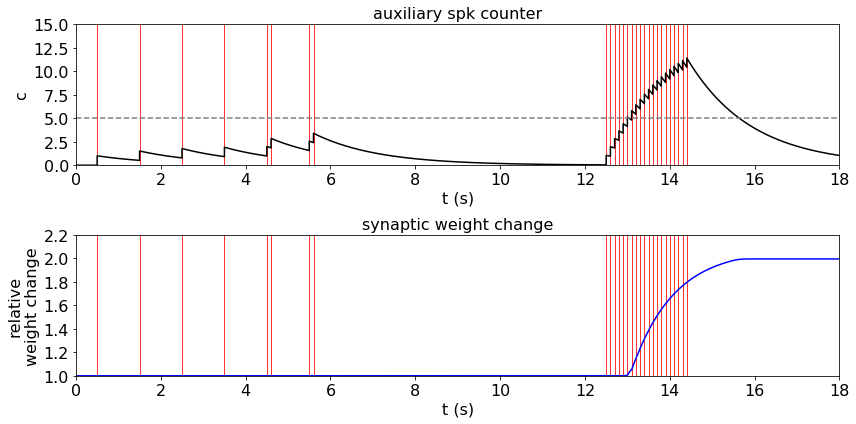

In [8]:
# demonstrate the counting variable (c) and weight change response to different spk trains
DUR = 18
spk_TIMES = [0.5, 1.5, 2.5, 3.5, 4.5, 4.6, 5.5, 5.6] \
    + list(12.5 + np.arange(0, 20)*0.1)

# initialize structures for storing spk-counter and synaptic weight
ts = np.arange(0, DUR, P.DT)
cs = np.nan * np.zeros(ts.shape)
ws = {'NMDA': np.nan * np.zeros((len(ts), 1))}

cs[0] = 0
ws['NMDA'][0] = P.W_N_EC_CA3_I

# make spk train
spks = np.zeros((len(ts), 1))

for t_spk in spk_TIMES:
    spks[int(t_spk/P.DT), 0] = 1

# run simulation
for step in range(1, len(ts)):

    # calc and store updated spk ctr
    cs_next = update_spk_ctr(spks[step], cs[step-1], t_c=P.T_C, dt=P.DT)
    cs[step] = cs_next

    # calc updated weights
    ws_prev = ws['NMDA'][step-1]
    ws_next = update_plastic_weights(
        cs=cs_next, ws_prev=ws_prev,
        c_s=P.C_S, beta_c=P.BETA_C, t_w=P.T_W,
        w_ec_ca3_max=P.W_N_EC_CA3_F, dt=P.DT)

    # store updated spk ctr and weights 
    cs[step] = cs_next
    ws['NMDA'][step] = ws_next


# make plots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)

# spks
for t_spk in spk_TIMES:
    for ax in axs:
        ax.axvline(t_spk, color='r', lw=0.8)
        
# counter
axs[0].plot(ts, cs, color='k', lw=1.5)
axs[0].axhline(P.C_S, color='gray', ls='--')
axs[0].set_ylim(0, 15)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('c')
axs[0].set_title('auxiliary spk counter')

# weight change
axs[1].plot(ts, ws['NMDA']/P.W_N_EC_CA3_I, color='b', lw=1.5)
axs[1].set_ylim(1, 2.2)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('relative\nweight change')
axs[1].set_title('synaptic weight change')

for ax in axs:
    ax.set_xlim(ts[0], ts[-1])
    set_font_size(ax, 16)

# INH - PC cxn weights

### Result: W_G_INH_PC = 0.024

We choose the GABA reversal potential and inhibitory connection weights to try to yield -2 mV IPSPs when CA3 PCs are at their resting potentials (Miles 1990).

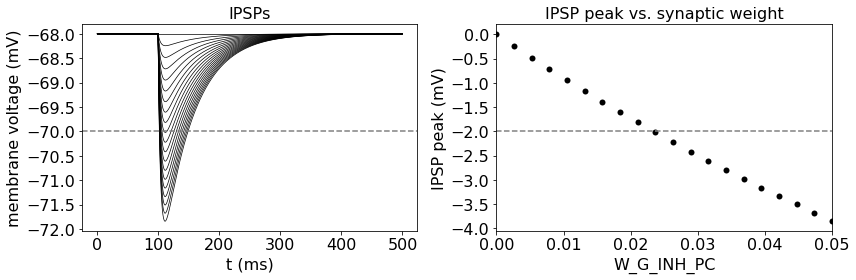

In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

WS_GABA = np.linspace(0, .05, 20)

ES_SYN = {'GABA': P.E_GABA}
TS_SYN = {'GABA': P.T_GABA}
WS_RCR = {'GABA': np.array([[0.]])}

# simulation parameters
DUR = 0.5  # (s)
INPUT_TIME = 0.1  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/P.DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([P.E_LEAK])
gs_init = {'GABA': np.array([0.])}

ipsp_peaks = np.nan * np.zeros(WS_GABA.shape)

for ctr, w_gaba in enumerate(WS_GABA):
    # make upstream weight matrix
    ws_up = {'GABA': np.array([[w_gaba]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    ipsp_peaks[ctr] = resp.vs.min() - resp.vs.max()

axs[0].axhline(-70, color='gray', ls='--')
axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('IPSPs')

axs[1].scatter(WS_GABA, 1000 * ipsp_peaks, c='k', lw=0)
axs[1].axhline(-2, color='gray', ls='--')
axs[1].set_xlim(WS_GABA[0], WS_GABA[-1])
axs[1].set_xlabel('W_G_INH_PC')
axs[1].set_ylabel('IPSP peak (mV)')
axs[1].set_title('IPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

This shows that a connection weight of approximately 0.024 yields a -2 mV IPSP.

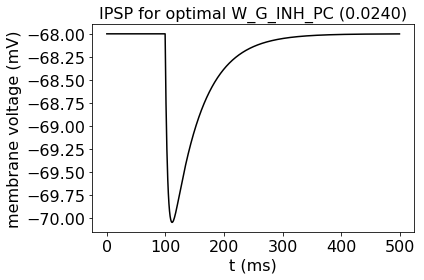

In [6]:
# show an IPSP from a place-tuned input with this AMPA weight
ws_up = {'GABA': np.array([[P.W_G_INH_PC]])}

# make and run ntwk
ntwk = LIFNtwk(
    t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1000 * ts, 1000 * resp.vs, color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('IPSP for optimal W_G_INH_PC ({0:.4f})'.format(P.W_G_INH_PC))
set_font_size(ax, 16)

# PC - INH cxn weights

### Result: W_A_PC_INH = 0.013

Here we determine the PC onto INH synaptic cxn strengths such that spikes onto INH neurons yield ~2 mV EPSPs.

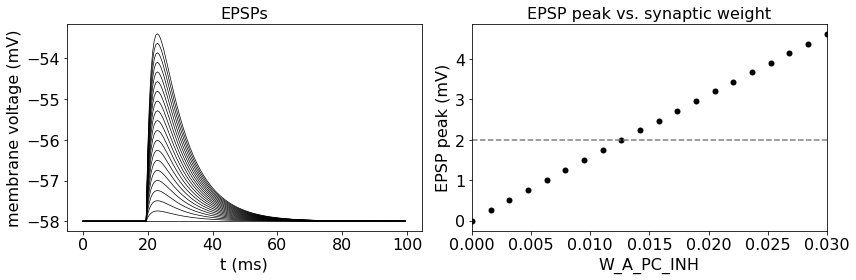

In [3]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

WS_AMPA = np.linspace(0, .03, 20)

ES_SYN = {'AMPA': P.E_AMPA}
TS_SYN = {'AMPA': P.T_AMPA}
WS_RCR = {'AMPA': np.array([[0.]])}

# simulation parameters
DUR = 0.1  # (s)
INPUT_TIME = 0.02  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/P.DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([P.E_LEAK_INH])
gs_init = {'AMPA': np.array([0.])}

epsp_peaks = np.nan * np.zeros(WS_AMPA.shape)

for ctr, w_ampa in enumerate(WS_AMPA):
    # make upstream weight matrix
    ws_up = {'AMPA': np.array([[w_ampa]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M_INH, e_leak=P.E_LEAK_INH, v_th=P.V_TH_INH, v_reset=P.V_RESET_INH, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    epsp_peaks[ctr] = resp.vs.max() - resp.vs.min()

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('EPSPs')

axs[1].scatter(WS_AMPA, 1000 * epsp_peaks, c='k', lw=0)
axs[1].axhline(2, color='gray', ls='--')
axs[1].set_xlim(WS_AMPA[0], WS_AMPA[-1])
axs[1].set_xlabel('W_A_PC_INH')
axs[1].set_ylabel('EPSP peak (mV)')
axs[1].set_title('EPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

The above results suggest that a cxn strength of about 0.013 yields the desired 2 mV EPSP.

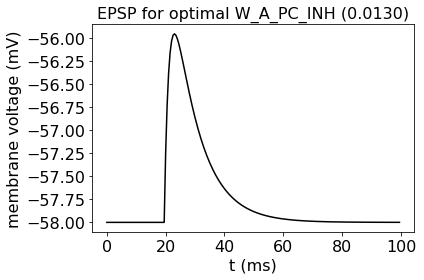

In [4]:
# show an EPSP from a place-tuned input with this AMPA weight
ws_up = {'AMPA': np.array([[P.W_A_PC_INH]])}

# make and run ntwk
ntwk = LIFNtwk(
    t_m=P.T_M_INH, e_leak=P.E_LEAK_INH, v_th=P.V_TH_INH, v_reset=P.V_RESET_INH, t_r=P.T_R,
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1000 * ts, 1000 * resp.vs, color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('EPSP for optimal W_A_PC_INH ({0:.4f})'.format(P.W_A_PC_INH))
set_font_size(ax, 16)

# Recurrent PC-PC synaptic weights

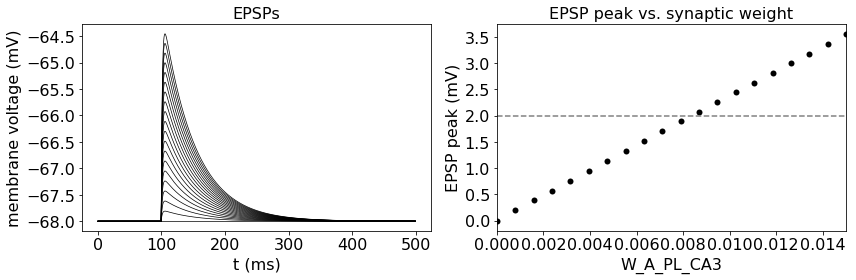

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

WS_AMPA = np.linspace(0, .015, 20)

ES_SYN = {'AMPA': P.E_A}
TS_SYN = {'AMPA': P.T_A}
WS_RCR = {'AMPA': np.array([[0.]])}

# simulation parameters
DUR = 0.5  # (s)
INPUT_TIME = 0.1  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/P.DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([P.E_L_PC])
gs_init = {'AMPA': np.array([0.])}

epsp_peaks = np.nan * np.zeros(WS_AMPA.shape)

for ctr, w_ampa in enumerate(WS_AMPA):
    # make upstream weight matrix
    ws_up = {'AMPA': np.array([[w_ampa]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=P.T_M_PC, e_leak=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
        es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    epsp_peaks[ctr] = resp.vs.max() - resp.vs.min()

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('EPSPs')

axs[1].scatter(WS_AMPA, 1000 * epsp_peaks, c='k', lw=0)
axs[1].axhline(2, color='gray', ls='--')
axs[1].set_xlim(WS_AMPA[0], WS_AMPA[-1])
axs[1].set_xlabel('W_A_PL_CA3')
axs[1].set_ylabel('EPSP peak (mV)')
axs[1].set_title('EPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

This shows that a synaptic AMPA weight of about 0.0085 yields a 2 mV EPSP.

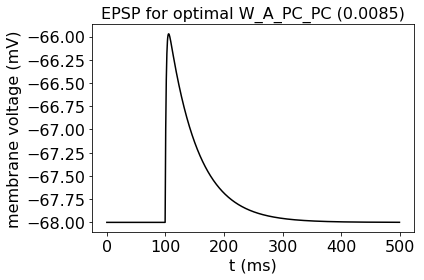

In [2]:
# show an EPSP from a place-tuned input with this AMPA weight
ws_up = {'AMPA': np.array([[P.W_A_PC_PC]])}

# make and run ntwk
ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_leak=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1000 * ts, 1000 * resp.vs, color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('EPSP for optimal W_A_PC_PC ({0:.4f})'.format(P.W_A_PC_PC))
set_font_size(ax, 16)